In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os, random
# os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
from transformers import EarlyStoppingCallback 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import torch

import evaluate

In [3]:
SEED = 1331

random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
from datasets import load_dataset

In [7]:
dataset = load_dataset('anurag2op/pcam-augmented-train-test-val-50k')

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
dataset = dataset.shuffle(seed=SEED)

In [11]:
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

In [12]:
MODEL_CKPT='facebook/convnextv2-tiny-1k-224'

NUM_OF_EPOCHS = 5

LEARNING_RATE=2e-4

STEPS=100

BATCH_SIZE = 16

In [13]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['non_tumor', 'tumor'], id=None)}

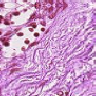

In [14]:
example = dataset["train"][2222]
example['image'] 

In [15]:
np.array(example['image']).shape

(96, 96, 3)

In [16]:
example['label']

0

In [17]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

creating id2label and label2id to decode the numbers back to string for convenience

In [18]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [19]:
id2label[0] , id2label[1] 

('non_tumor', 'tumor')

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the 'AutoImageProcessor.from_pretrained' method.

In [20]:
image_processor  = AutoImageProcessor.from_pretrained(MODEL_CKPT)

In [21]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [22]:
from torchvision.transforms import (
    Normalize,
    Compose,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    
transforms = Compose(
        [
            Resize(image_processor.size['shortest_edge']),
            ToTensor(),
            normalize
        ]
    )

def preprocess(example_batch):
    
    """Apply train_transforms across a batch."""
    
    example_batch["pixel_values"] = [
        transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    
    return example_batch


In [23]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)

In [24]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 1,
 'pixel_values': tensor([[[ 1.1358,  1.1187,  1.0844,  ...,  0.8961,  0.8961,  0.8961],
          [ 1.1358,  1.1187,  1.0844,  ...,  0.9303,  0.9303,  0.9303],
          [ 1.1015,  1.1015,  1.0844,  ...,  1.0673,  1.0673,  1.0673],
          ...,
          [-0.5424, -0.3198,  0.3138,  ...,  1.1872,  1.1872,  1.1872],
          [-0.5424, -0.3198,  0.3138,  ...,  1.1872,  1.1872,  1.1872],
          [-0.5424, -0.3198,  0.3138,  ...,  1.1872,  1.1872,  1.1872]],
 
         [[ 0.7129,  0.6954,  0.6604,  ...,  0.6078,  0.6078,  0.6078],
          [ 0.7304,  0.7129,  0.6779,  ...,  0.6429,  0.6429,  0.6429],
          [ 0.7479,  0.7479,  0.7304,  ...,  0.7829,  0.7829,  0.7829],
          ...,
          [-1.0728, -0.8452, -0.1450,  ...,  1.0980,  1.0980,  1.0980],
          [-1.0728, -0.8452, -0.1450,  ...,  1.0980,  1.0980,  1.0980],
          [-1.0728, -0.8452, -0.1450,  ...,  1.0980,  1.0980,  1.0980]],
 


In [25]:
train_ds[0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [26]:
model = ConvNextV2ForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels= 2,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to(device)

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model

ConvNextV2ForImageClassification(
  (convnextv2): ConvNextV2Model(
    (embeddings): ConvNextV2Embeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextV2LayerNorm()
    )
    (encoder): ConvNextV2Encoder(
      (stages): ModuleList(
        (0): ConvNextV2Stage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextV2Layer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextV2LayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (grn): ConvNextV2GRN()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextV2Layer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
    

In [28]:
model_name = MODEL_CKPT.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-pcam-finetuned",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs'
)

In [29]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [30]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer = image_processor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn,
    callbacks=[early_stopping]
    
)

In [32]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.349500,0.296202,0.875400,0.875312,0.875400,0.875312,0.875400,0.875400,0.875400,0.876465,0.875400,0.876465
2,0.206900,0.260258,0.899700,0.899566,0.899700,0.899566,0.899700,0.899700,0.899700,0.901841,0.899700,0.901841
3,0.131400,0.270242,0.910800,0.910785,0.910800,0.910785,0.910800,0.910800,0.910800,0.911069,0.910800,0.911069
4,0.003700,0.338691,0.916300,0.916282,0.916300,0.916282,0.916300,0.916300,0.916300,0.916650,0.916300,0.916650
5,0.001500,0.415143,0.919900,0.919886,0.919900,0.919886,0.919900,0.919900,0.919900,0.920188,0.919900,0.920188


In [33]:
trainer.save_model()

In [34]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 3516140840GF
  train_loss               =       0.1976
  train_runtime            =   0:40:55.29
  train_samples_per_second =       61.093
  train_steps_per_second   =        3.818


In [35]:
trainer.save_state()

In [36]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_Macro F1           =     0.9235
  eval_Macro Precision    =     0.9238
  eval_Macro Recall       =     0.9235
  eval_Micro F1           =     0.9235
  eval_Micro Precision    =     0.9235
  eval_Micro Recall       =     0.9235
  eval_Weighted F1        =     0.9235
  eval_Weighted Precision =     0.9238
  eval_Weighted Recall    =     0.9235
  eval_accuracy           =     0.9235
  eval_loss               =     0.4113
  eval_runtime            = 0:01:02.31
  eval_samples_per_second =    160.485
  eval_steps_per_second   =      10.03


In [37]:
predictions = trainer.predict(test_ds)

In [38]:
predictions[0]

array([[ 3.4189875, -3.4189663],
       [ 3.5527198, -3.5526974],
       [ 3.6391082, -3.6390836],
       ...,
       [ 2.5688488, -2.5688326],
       [-4.326426 ,  4.3263936],
       [-3.9968445,  3.9968119]], dtype=float32)

In [39]:
y_pred = np.argmax(predictions[0],axis=1)

In [40]:
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [41]:
y_pred.shape

(10000,)

In [42]:
y_test = []

for i,j in enumerate(test_ds):
    y_test.append(test_ds[i]['label'])

In [43]:
y_test = np.array(y_test)

In [44]:
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
y_test.shape

(10000,)

In [46]:
print(confusion_matrix(y_test,y_pred))

[[4682  318]
 [ 447 4553]]


In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5000
           1       0.93      0.91      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [48]:
target_classes=[]

label_map = { 0 :'non_tumor', 1:"tumor"}


for i in label_map.values():
    target_classes.append(i) 

In [49]:
target_classes

['non_tumor', 'tumor']

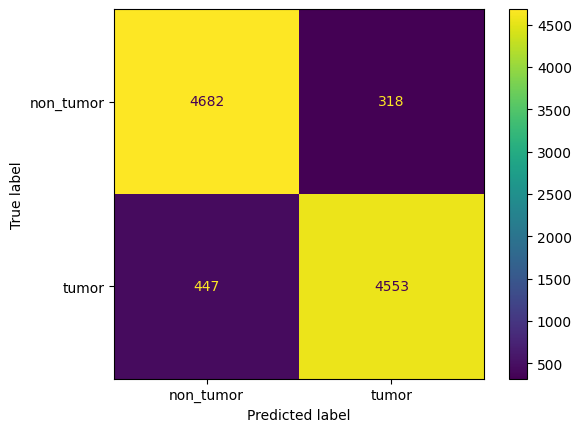

In [50]:
ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred), display_labels=target_classes)
ax.plot()
plt.savefig('ConvnextV2.png',format= 'png')
plt.show()

In [52]:
repo_name = "convnextv2-tiny-1k-224-pcam-finetuned"

model.push_to_hub(repo_name)
image_processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anurag2op/convnextv2-tiny-1k-224-pcam-finetuned/commit/090846de4a4405248cae9d5c2948dbec79ad2f84', commit_message='Upload processor', commit_description='', oid='090846de4a4405248cae9d5c2948dbec79ad2f84', pr_url=None, pr_revision=None, pr_num=None)